In [28]:
import numpy as np
import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from tqdm import tqdm
import ray
ray.init(ignore_reinit_error=True)

2025-01-02 21:29:18,273	INFO worker.py:1654 -- Calling ray.init() again after it has already been called.


Python version:,3.12.7
Ray version:,2.40.0


In [29]:

path = os.path.join(os.getcwd(), 'names')
all_filenames = [i for i in glob.glob(f'{path}/*.txt')]
dfs = []

for filename in tqdm(all_filenames):
    df = pd.read_csv(filename,header=None)
    year = os.path.basename(filename).split(".")[0]
    df[3] = year 
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True,axis=0)
combined_df.to_csv('allnames.csv', index=False)


100%|██████████| 144/144 [00:05<00:00, 25.94it/s]


In [30]:
df = pd.read_csv('allnames.csv', header=None,low_memory=False)
df.columns=['Names','Sex','Count','Year']
df = df.drop(0)
df.head(5)

,Names,Sex,Count,Year
1,Mary,F,7065,1880
2,Anna,F,2604,1880
3,Emma,F,2003,1880
4,Elizabeth,F,1939,1880
5,Minnie,F,1746,1880


In [31]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 2117219 entries, 1 to 2117219
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Names   object
 1   Sex     object
 2   Count   int64 
 3   Year    int64 
dtypes: int64(2), object(2)
memory usage: 80.8+ MB


In [32]:
df_grouped = df.drop('Names', axis=1).groupby(['Sex','Year'])['Count'].sum().reset_index()
df_grouped

,Sex,Year,Count
0,F,1880,90994
1,F,1881,91953
2,F,1882,107847
3,F,1883,112320
4,F,1884,129019
...,...,...,...
283,M,2019,1792223
284,M,2020,1723649
285,M,2021,1746499
286,M,2022,1741954


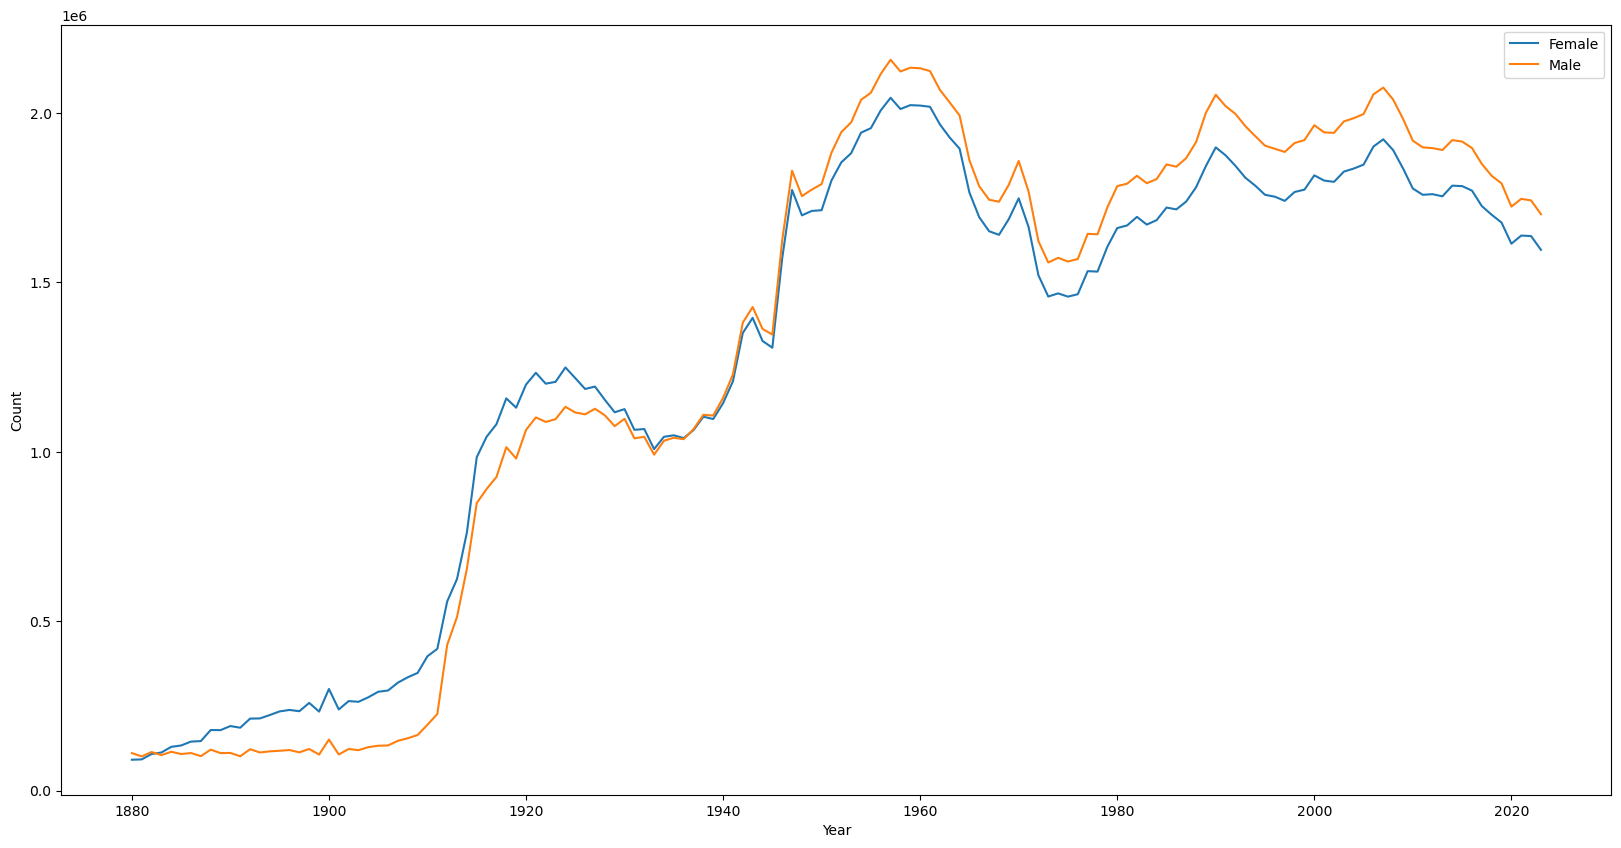

In [ ]:

f, ax = plt.subplots(figsize=(20,10))

# Filter the dataframe for females and plot
df_female = df_grouped[df_grouped['Sex'] == 'F']
sns.lineplot(y= df_female['Count'], x= df_female['Year'], ax=ax, label='Female')

# Filter the dataframe for males and plot
df_male = df_grouped[df_grouped['Sex'] == 'M']
sns.lineplot(y= df_male['Count'], x= df_male['Year'], ax=ax, label='Male')

ax.legend()
plt.show()

In [35]:
popname = df.groupby(['Sex','Year'])['Count'].max().reset_index()
popname = popname.sort_values('Year')
popname = pd.merge(popname, df, on=['Sex', 'Year', 'Count'])
popname

,Sex,Year,Count,Names
0,F,1880,7065,Mary
1,M,1880,9655,John
2,F,1881,6919,Mary
3,M,1881,8768,John
4,F,1882,8148,Mary
...,...,...,...,...
283,F,2021,17824,Olivia
284,M,2022,20533,Liam
285,F,2022,16630,Olivia
286,F,2023,15270,Olivia


In [36]:
alltime = df.groupby(['Names','Sex'])['Count'].sum().reset_index()
Top10Male = alltime[alltime['Sex']=='M'].nlargest(10, 'Count').reset_index()
Top10Female = alltime[alltime['Sex']=='F'].nlargest(10, 'Count').reset_index()

Top10 = pd.concat([Top10Male['Names'],Top10Female['Names']], axis=1)

Top10.columns = ['Male', 'Female']
Top10

,Male,Female
0,James,Mary
1,John,Elizabeth
2,Robert,Patricia
3,Michael,Jennifer
4,William,Linda
5,David,Barbara
6,Joseph,Margaret
7,Richard,Susan
8,Charles,Dorothy
9,Thomas,Sarah
